# GAN para la generación de datos del estado de la atmósfera.

Se va a ocupar una red tipo GAN para obtener un generador de datos que despues será usado en un autonecoder.


### Preparando entorno

Carga de librarías, modulos y revición del uso de la GPU

In [1]:
import os
import sys
import time
import h5py
import pickle
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path

import trainconfig
sys.path.append(trainconfig.DIR_LIB)
sys.path.append(trainconfig.DIR_MODELOS)
import datasets
import modelos

import importlib
importlib.reload(datasets)
importlib.reload(modelos)
importlib.reload(trainconfig)

# Vemos si hay GPUs disponibles, y configuramos para que no use toda la memoria.
trainconfig.ver_gpus()

Name: /physical_device:GPU:0   Type: GPU


2022-08-03 22:09:19.750682: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 22:09:19.788411: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 22:09:19.788739: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


### Preparando dataset

Preparación de los datos para usar con la GAN.

In [2]:
trainconfig.preparar_dataset_GAN()

Ya existen los datasets preparados,si desea volver a generarlos eliminelos y vulva a ejecutar la función.


### Preparando secuenciador

Secuenciador para la carga de los batches sin saturar la memoria RAM del sistema ni de la GPU

In [1]:
lista_keys_X = ["CTH","COD","CM"]
lista_keys_y = None

def callback_x(inputs):
    return (inputs*2 - 1) 
    

secuenciador = trainconfig.SecuenciaHDF5(
    X_keys = lista_keys_X,
    Y_keys = lista_keys_y,
    batch_size= trainconfig.BATCH_SIZE,
    path_dataset= trainconfig.PATH_DATASET_GAN,
    callback_x = callback_x,
)

NameError: name 'trainconfig' is not defined

### Visualización rápida del dataset

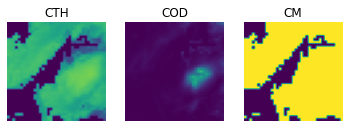

In [4]:
X, _ = secuenciador.__getitem__(0)

index  = 3

fig,ax = plt.subplots(1,3)

for i in range(3): ax[i].axis("off")

ax[0].set_title("CTH")
ax[0].imshow(X[index,:,:,0],vmin=-1,vmax=1)

ax[1].set_title("COD")
ax[1].imshow(X[index,:,:,1],vmin=-1,vmax=1)

ax[2].set_title("CM")
ax[2].imshow(X[index,:,:,2],vmin=-1,vmax=1)



In [5]:
modelo_generador = modelos.Modelo_GAN_generador()
modelo_generador.summary()

modelo_discriminador = modelos.Modelo_GAN_discriminador()
modelo_discriminador.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 dense (Dense)               (None, 4050)              206550    
                                                                 
 tf.reshape (TFOpLambda)     (None, 9, 9, 50)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 18, 18, 64)       51200     
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 18, 18, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 36, 36, 64)       65536 

2022-08-03 22:09:20.145098: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-03 22:09:20.145756: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 22:09:20.146192: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 22:09:20.146492: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

2022-08-03 22:09:21.479281: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8300
2022-08-03 22:09:22.113955: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


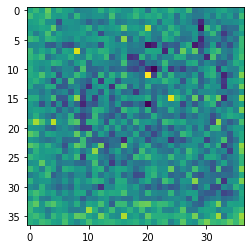

In [6]:
noise = tf.random.normal([1,50])
plt.imshow(modelo_generador(noise).numpy().reshape((37,37,3))[:,:,0])

In [12]:
LOSS = 1e-4

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def coste_discriminador(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def coste_generador(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generador_optimizer     = tf.keras.optimizers.Adam(LOSS,beta_1=0.5,)
discriminador_optimizer = tf.keras.optimizers.Adam(LOSS,beta_1=0.5,)

In [13]:
class train_manager:
    def __init__(self,reiniciar=False):
        # Parámetros principales
        self.num_ejemplos = 8
        # Paths
        self.path = "GAN_train_info"
        self.path_imagenes = f"{self.path}/Progreso/"
        self.path_dic_hist = f"{self.path}/historial.dic"
        # Inicializamos los parámetros
        self.epoch = 0
        self.tiempo_entrenamiento = 0
        self.historial_gen_loss   = []
        self.historial_disc_loss  = []
        self.historial_tiempo_epoch = []
        self.noise_prueba = tf.random.normal([self.num_ejemplos,trainconfig.GAN_NOISE_DIM])
        # Inicializamos checkpoint
        self.checkpoint_dir  = f"{self.path}/training_checkpoints/"
        self.checkpoint_prefix = os.path.join(self.checkpoint_dir, "ckpt")
        self.checkpoint  = tf.train.Checkpoint(
            generator_optimizer=generador_optimizer,
            discriminator_optimizer=discriminador_optimizer,
            generator=modelo_generador,
            discriminator=modelo_discriminador,
        )
        # Si reiniciar == True: Borramos toda la info anterior.
        if reiniciar:
            confirmacion = input("Se va a borrar todo el progreso, continuar? [Y/n]")
            if confirmacion == "Y":
                #Revisamos que exista el directorio del progreso.
                if os.path.exists(f"{self.path}/") and os.path.isdir(f"{self.path}/"):
                    shutil.rmtree(f"{self.path}/")
                else:
                    print("No se ha borrado el progreso.")
                    
        # Revisamos que exista info guardada si no empezamoms de cero.
        if  not os.path.exists(f"{self.path}/historial.dic"):
            Path(self.path).mkdir(parents=True, exist_ok=True)
            Path(self.path_imagenes).mkdir(parents=True, exist_ok=True)    
        else:
            # Si existe inicializamos todo.
            self._restore_last_checkpoint()
    
    def _restaurar_dic_hist(self):
        "Restaura los valores de entrenamiento"
        with open(self.path_dic_hist,"rb") as file:
            dic_hist = pickle.load(file)
        self.epoch = dic_hist["epoch"]
        self.tiempo_entrenamiento   = dic_hist["t_train"]
        self.historial_gen_loss     = dic_hist["gen_loss"]
        self.historial_disc_loss    = dic_hist["disc_loss"]
        self.historial_tiempo_epoch = dic_hist["t_hist"]
        self.noise_prueba = tf.constant(dic_hist["noise"],dtype=tf.float32)
    
    def _guardar_dic_hist(self):
        dic_hist = {
            "epoch" : self.epoch,
            "t_train" : self.tiempo_entrenamiento,
            "gen_loss" : self.historial_gen_loss,
            "disc_loss" : self.historial_disc_loss,
            "t_hist" : self.historial_tiempo_epoch,
            "noise"  : self.noise_prueba.numpy()
        }
        with open(self.path_dic_hist,"wb") as file:
            pickle.dump(dic_hist,file)
    
    def _restore_last_checkpoint(self,):
        self._restaurar_dic_hist()
        self.checkpoint.restore(tf.train.latest_checkpoint(self.checkpoint_dir))
        print("Restaurado el último checkpoint.")
    
    def _graficar_progreso(self,guardar=True):
        # Obtenemos el número de ejemplos
        num_ejemplos = self.noise_prueba.shape[0]
        # Generamos el tamaño de la gráfica
        tam_x = (num_ejemplos+1)*5 + 3
        tam_y = 10
        # Transformamos tiempo en horas
        t = round(self.tiempo_entrenamiento / 3600,3)
        # Generamos imágenes
        imagen_generada = modelo_generador(self.noise_prueba,training=False).numpy()
        # Graficamos
        fig, ax = plt.subplots(2,num_ejemplos+1,figsize=(tam_x,tam_y),dpi=150)
        fig.suptitle(f"Epoch {self.epoch}, T: {t} horas",weight="bold",fontsize=30)
        for i in range(num_ejemplos):
            ax[0,i].axis("off")
            ax[1,i].axis("off")
            ax[0,i].set_title(f"Ejemplo #{i+1}",fontsize=20)
            ax[0,i].imshow(imagen_generada[i,:,:,0],vmin=-1,vmax=1)
            ax[1,i].imshow(imagen_generada[i,:,:,1],vmin=-1,vmax=1)
         # Graficamos historial del costo
        ax[0,num_ejemplos].set_title(f"Historial del coste",fontsize=12,weight="bold")
        ax[0,num_ejemplos].plot(self.historial_gen_loss,label="generative loss")
        ax[0,num_ejemplos].plot(self.historial_disc_loss,label="discrimintive loss")
        ax[0,num_ejemplos].legend()
        ax[0,num_ejemplos].set_xlabel("Epoch")
        ax[0,num_ejemplos].set_ylabel("Loss")
        # Graficamos historial del tiempo por epoch
        ax[1,num_ejemplos].set_title(f"Historial del tiempo por epoch",fontsize=12,weight="bold")
        ax[1,num_ejemplos].plot(self.historial_tiempo_epoch)
        ax[1,num_ejemplos].set_xlabel("Epoch")
        ax[1,num_ejemplos].set_ylabel("Tiempo (segundos)")
        # Guardamos gráfica
        if guardar:
            plt.savefig(f"{self.path_imagenes}epoch_{self.epoch}.jpg")
            plt.close()
        else:
            plt.show()
    
    @tf.function
    def _train_step(self,imagenes):
        # Generamos el ruido
        noise_input = tf.random.normal([trainconfig.BATCH_SIZE,trainconfig.GAN_NOISE_DIM])
        # Grabamos las operaciones
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # Generamos las imágenes apartir del ruido
            imagenes_generadas = modelo_generador(noise_input,training=True)
            # Evaluamos el discriminador sobre las imágenes reales y generadas
            output_real  = modelo_discriminador(imagenes,training=True)
            output_falso = modelo_discriminador(imagenes_generadas,training=True)
            # Evaluamos las funciones de coste
            coste_gen  = coste_generador(output_falso)
            coste_disc = coste_discriminador(output_real,output_falso)
            # Calculamos los gradientes
            gradientes_generador = gen_tape.gradient(coste_gen,modelo_generador.trainable_variables)
            gradientes_discriminador = disc_tape.gradient(coste_disc,modelo_discriminador.trainable_variables)
            # Con los optimizadores actualizamos los parámetros
            generador_optimizer.apply_gradients(zip(gradientes_generador, modelo_generador.trainable_variables))
            discriminador_optimizer.apply_gradients(zip(gradientes_discriminador, modelo_discriminador.trainable_variables))
        return coste_gen , coste_disc
            
    def train(self,secuenciador,epochs,verbose=True):
        print(f"Iniciando entrenamiento desde el epoch {self.epoch}:")
        try:
            num_batches = secuenciador.__len__()
            for _ in range(epochs):
                t_inicio_epoch = time.time()
                # Entrenamiento con cada uno de los batches
                GEN_LOSS ,DISC_LOSS = [] , []
                for batch in range(num_batches):
                    imagenes , _ = secuenciador.__getitem__(batch)
                    gen_loss,disc_loss = self._train_step(imagenes)
                    GEN_LOSS.append(gen_loss.numpy())
                    DISC_LOSS.append(disc_loss.numpy())
                # Obtenemos métricas
                tiempo_epoch = time.time() - t_inicio_epoch
                gen_loss , disc_loss = np.mean(DISC_LOSS) , np.mean(GEN_LOSS)
                # Actualizamos historial
                self.historial_gen_loss.append(gen_loss)
                self.historial_disc_loss.append(disc_loss)
                self.historial_tiempo_epoch.append(tiempo_epoch)
                self.epoch += 1
                self.tiempo_entrenamiento += tiempo_epoch
                # Guardamos historial
                self._guardar_dic_hist()
                # Guardamos checkpoint
                self.checkpoint.save(file_prefix = self.checkpoint_prefix)
                if verbose:
                    print ('Epoch {0:3d} in {1:4.1f} sec : gen_loss {2:5.3f} , disc_loss {3:5.3f}'.format(self.epoch + 1,tiempo_epoch,gen_loss,disc_loss))
                self._graficar_progreso()
        except KeyboardInterrupt:
            print("Interrupción de teclado, termminando el entrenamiento.")
            self._graficar_progreso(guardar=False)

Se va a borrar todo el progreso, continuar? [Y/n]Y
Iniciando entrenamiento desde el epoch 0:
Epoch   2 in 321.5 sec : gen_loss 1.078 , disc_loss 1.062
Epoch   3 in 329.8 sec : gen_loss 1.293 , disc_loss 0.802
Epoch   4 in 315.6 sec : gen_loss 1.138 , disc_loss 0.925
Epoch   5 in 321.1 sec : gen_loss 1.164 , disc_loss 0.873
Epoch   6 in 315.0 sec : gen_loss 1.137 , disc_loss 0.908
Epoch   7 in 314.5 sec : gen_loss 1.074 , disc_loss 0.988
Epoch   8 in 315.1 sec : gen_loss 1.043 , disc_loss 1.054
Epoch   9 in 314.6 sec : gen_loss 0.999 , disc_loss 1.146
Epoch  10 in 314.6 sec : gen_loss 1.049 , disc_loss 1.090
Epoch  11 in 316.3 sec : gen_loss 1.027 , disc_loss 1.119
Epoch  12 in 321.4 sec : gen_loss 1.003 , disc_loss 1.166
Epoch  13 in 317.8 sec : gen_loss 1.044 , disc_loss 1.085
Epoch  14 in 315.1 sec : gen_loss 1.159 , disc_loss 1.034
Epoch  15 in 314.6 sec : gen_loss 1.183 , disc_loss 1.034
Epoch  16 in 317.2 sec : gen_loss 1.181 , disc_loss 0.988
Epoch  17 in 314.1 sec : gen_loss 1.1

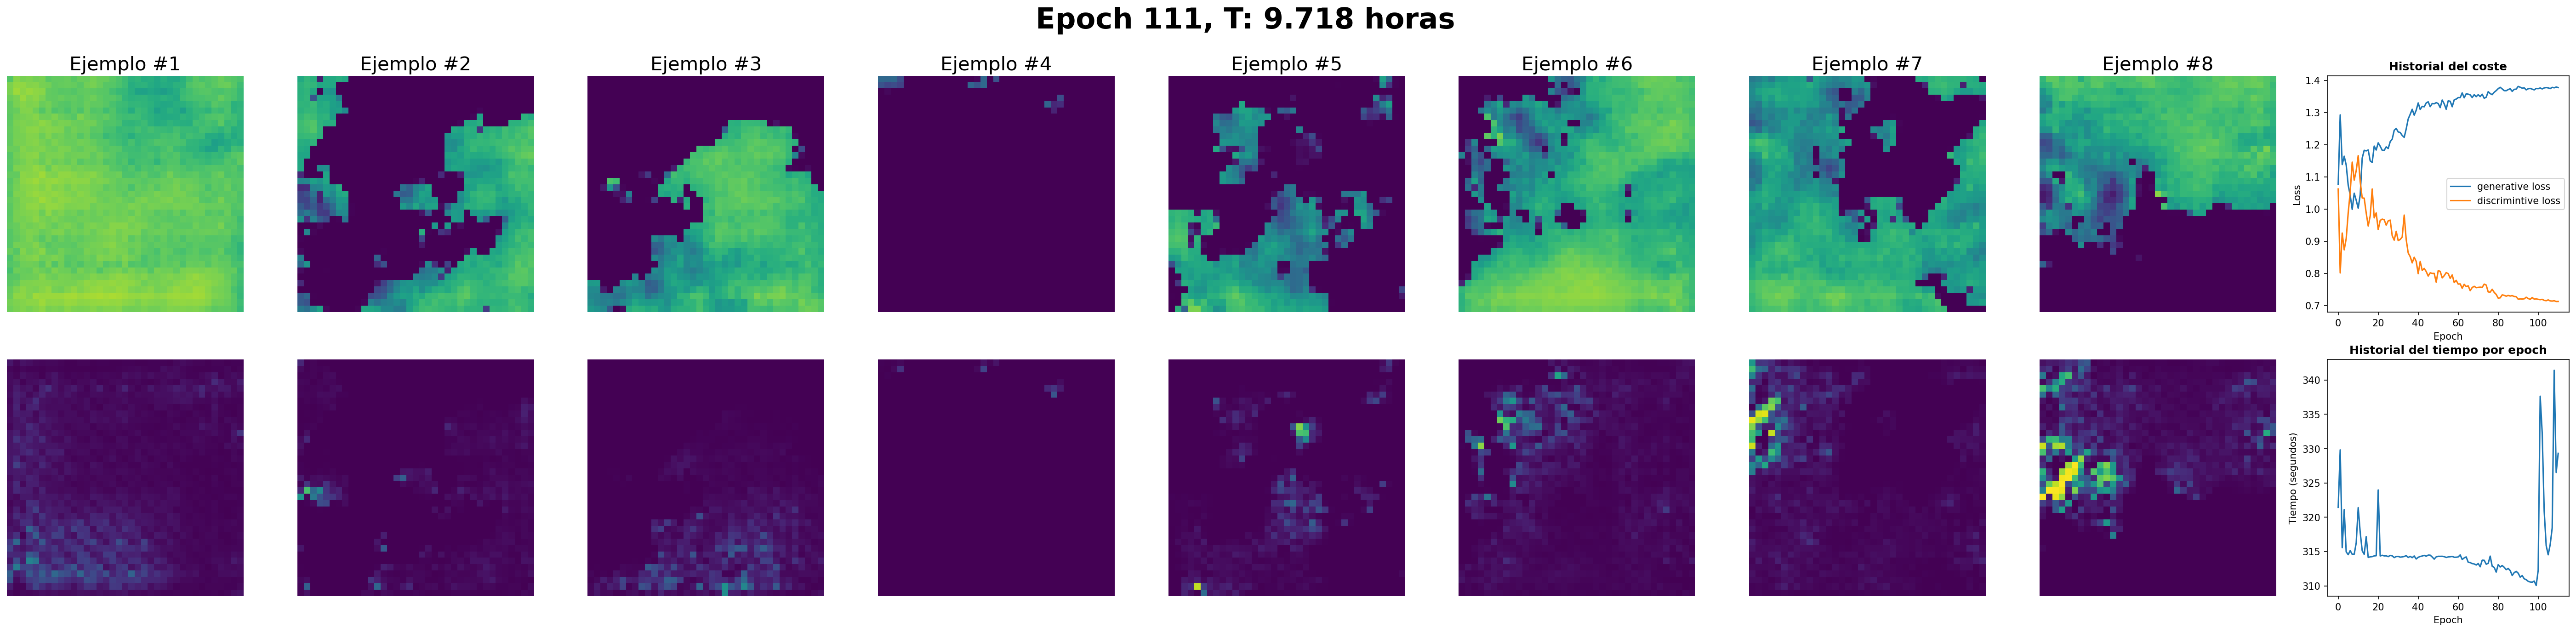

In [14]:
manager = train_manager(reiniciar=True)
manager.train(secuenciador,epochs=500)

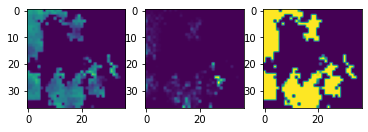

In [230]:
# Probamos un checkpoint específico
num_checkpoint = 103
manager.checkpoint.restore(f"{manager.checkpoint_dir}ckpt-{num_checkpoint}")

noise = tf.random.normal([1,50])
fig,ax = plt.subplots(1,3)
ax[0].imshow(modelo_generador(noise).numpy().reshape((37,37,3))[:,:,0],vmin=-1,vmax=1)
ax[1].imshow(modelo_generador(noise).numpy().reshape((37,37,3))[:,:,1],vmin=-1,vmax=1)
ax[2].imshow(modelo_generador(noise).numpy().reshape((37,37,3))[:,:,2],vmin=-1,vmax=1)


In [231]:
# Ya que elegimos el checkpoint, lo guardamos

modelo_generador.save_weights(f"{trainconfig.DIR_PESOS}/GAN_gen/pesos.tf",save_format="tf")
print(f"Pesos guardados en {trainconfig.DIR_PESOS}/GAN_gen/pesos.tf")

Pesos guardados en /home/felos/Repos/Deep-GOES/Modelos/Pesos//GAN_gen/pesos.tf
